In [1]:
# Load Artifacts
import json, joblib, numpy as np, pandas as pd
from pathlib import Path

OUT_DIR = Path(r"C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs")
INT_DIR = OUT_DIR / "interim"
FIG_DIR = OUT_DIR / "figs"
(FIG_DIR / "shapes").mkdir(parents=True, exist_ok=True)

Xtr = joblib.load(INT_DIR/"Xtr.pkl"); Xva = joblib.load(INT_DIR/"Xva.pkl"); Xte = joblib.load(INT_DIR/"Xte.pkl")
ytr = joblib.load(INT_DIR/"ytr.npy"); yva = joblib.load(INT_DIR/"yva.npy"); yte = joblib.load(INT_DIR/"yte.npy")
Xtr_t = joblib.load(INT_DIR/"Xtr_t.npy"); Xva_t = joblib.load(INT_DIR/"Xva_t.npy"); Xte_t = joblib.load(INT_DIR/"Xte_t.npy")
preproc = joblib.load(INT_DIR/"preproc.joblib")
meta = json.load(open(INT_DIR/"meta.json","r",encoding="utf-8"))
df = pd.read_parquet(INT_DIR/"df_filtered.parquet")

feature_cols = meta["feature_cols"]; num_cols = meta["num_cols"]; bin_cols = meta["bin_cols"]; cat_cols = meta["cat_cols"]

p_logit = joblib.load(INT_DIR/"p_logit.npy")
p_xgb   = joblib.load(INT_DIR/"p_xgb.npy")
p_gnam  = joblib.load(INT_DIR/"p_gnam.npy")
p_final = joblib.load(INT_DIR/"p_final.npy")


In [2]:
# **Table 0**(not include)
import pandas as pd, numpy as np
from pathlib import Path

OUT_DIR.mkdir(parents=True, exist_ok=True)

def miss_table(df_in, cols=None):
    use = df_in if cols is None else df_in[cols]
    m = use.isna().mean().sort_values(ascending=False)
    res = pd.DataFrame({
        "feature": m.index,
        "missing_rate": m.values,
        "n_missing": use.shape[0] * m.values,
        "n_non_missing": use.shape[0] * (1 - m.values),
        "n_unique": [use[c].nunique(dropna=True) for c in m.index],
    })
    return res

cohort_n = len(df)
death_n = int((df["EVOLUCAO"] == 2).sum())
death_rate = death_n / max(cohort_n,1)

date_min = pd.to_datetime(df["DT_INTERNA"], errors="coerce").min()
date_max = pd.to_datetime(df["DT_INTERNA"], errors="coerce").max()

df_all = pd.concat([Xtr, Xva, Xte], axis=0, ignore_index=False)
tbl_missing = miss_table(df_all, cols=feature_cols).sort_values("missing_rate", ascending=False)

table1_head = pd.DataFrame({
    "Item": ["N (cohort)","Deaths (N)","Death rate","Admission date (min)","Admission date (max)"],
    "Value": [cohort_n, death_n, round(death_rate,4), str(date_min.date() if pd.notna(date_min) else None), str(date_max.date() if pd.notna(date_max) else None)]
})

(OUT_DIR/"table1_cohort_summary.csv").write_text(table1_head.to_csv(index=False))
tbl_missing.to_csv(OUT_DIR/"table1_missingness_full.csv", index=False)

print("Table 1")
print(OUT_DIR/"table1_cohort_summary.csv")
print(OUT_DIR/"table1_missingness_full.csv")
display(table1_head)
display(tbl_missing.head(30))


Table 1
C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\table1_cohort_summary.csv
C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\table1_missingness_full.csv


Item       Value
0            N (cohort)      307075
1            Deaths (N)      105980
2            Death rate      0.3451
3  Admission date (min)  2020-02-25
4  Admission date (max)  2020-09-21

feature  missing_rate  n_missing  n_non_missing  n_unique
0        TABAG      1.000000   307075.0            0.0         0
1      DOR_ABD      0.698846   214598.0        92477.0         2
2    PERD_PALA      0.697732   214256.0        92819.0         2
3    PERD_OLFT      0.696729   213948.0        93127.0         2
4       FADIGA      0.691154   212236.0        94839.0         2
5     HEPATICA      0.596255   183095.0       123980.0         2
6   HEMATOLOGI      0.595180   182765.0       124310.0         2
7   IMUNODEPRE      0.590888   181447.0       125628.0         2
8    OBESIDADE      0.589869   181134.0       125941.0         2
9         ASMA      0.589647   181066.0       126009.0         2
10  PNEUMOPATI      0.584909   179611.0       127464.0         2
11       RENAL      0.584150   179378.0       127697.0         2
12  NEUROLOGIC      0.583522   179185.0       127890.0         2
13    DIABETES      0.497953   152909.0       154166.0         2
14  CARDIOPATI      0.462988   142172.0       164903.0         2
15      VOMITO      0.283488    87052.0       220023.0         2
16     EDU_ORD      0.279570    85849.0       221226.0         7
17  CS_ESCOL_N      0.279570    85849.0       221226.0         7
18   AGE_X_EDU      0.279570    85849.0       221226.0       329
19   OUTRO_SIN      0.268550    82465.0       224610.0         2
20    DIARREIA      0.267567    82163.0       224912.0         2
21    GARGANTA      0.259152    79579.0       227496.0         2
22   DESC_RESP      0.167187    51339.0       255736.0         2
23       FEBRE      0.113200    34761.0       272314.0         2
24    DISPNEIA      0.104284    32023.0       275052.0         2
25       TOSSE      0.098419    30222.0       276853.0         2
26     CS_RACA      0.057823    17756.0       289319.0         6
27          UF      0.000896      275.0       306800.0        27
28       AGE_Y      0.000000        0.0       307075.0       111
29    EPI_WEEK      0.000000        0.0       307075.0        53

In [3]:
# Table 2
import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

def _safe_logit(p, eps=1e-12):
    p = np.asarray(p, dtype=float)
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))

def _fit_calib_lr(z, y):
    try:
        lr = LogisticRegression(penalty=None, solver="lbfgs", max_iter=2000)
        lr.fit(z, y)
        return float(lr.coef_[0,0]), float(lr.intercept_[0])
    except Exception:
        lr = LogisticRegression(penalty="l2", C=1e6, solver="lbfgs", max_iter=2000)
        lr.fit(z, y)
        return float(lr.coef_[0,0]), float(lr.intercept_[0])

def calib_slope_intercept(y_true, p_pred):
    y = np.asarray(y_true, dtype=float)
    z = _safe_logit(p_pred).reshape(-1,1)
    if np.unique(y).size < 2 or np.isfinite(z).sum() != len(z):
        return np.nan, np.nan
    slope, intercept = _fit_calib_lr(z, y)
    return slope, intercept

def expected_over_observed(y_true, p_pred):
    y = np.asarray(y_true, dtype=float)
    p = np.asarray(p_pred, dtype=float)
    E, O = float(np.nansum(p)), float(np.nansum(y))
    return (E / O) if O > 0 else np.nan

def collect_row(name, y, p):
    auroc = float(roc_auc_score(y, p)) if np.unique(y).size > 1 else np.nan
    ap    = float(average_precision_score(y, p)) if np.unique(y).size > 1 else np.nan
    brier = float(brier_score_loss(y, p))
    slope, intercept = calib_slope_intercept(y, p)
    eo = expected_over_observed(y, p)
    return {"model": name,"AUROC": auroc,"PR-AUC": ap,"Brier": brier,"Cal_slope": slope,"Cal_intercept": intercept,"E:O": eo}

rows = []
rows.append(collect_row("Logistic",   yte, p_logit))
rows.append(collect_row("XGBoost",    yte, p_xgb))
rows.append(collect_row("GNAM",       yte, p_gnam))
rows.append(collect_row("GNAM-Boost", yte, p_final))

table2 = pd.DataFrame(rows).sort_values("AUROC", ascending=False)
display(table2)

table2_path = OUT_DIR / "table2_model_compare_metrics.csv"
table2.to_csv(table2_path, index=False)
print("Table 2", table2_path)


model     AUROC    PR-AUC     Brier  Cal_slope  Cal_intercept  \
1     XGBoost  0.798422  0.661830  0.169116   0.990162      -0.006532   
3  GNAM-Boost  0.797757  0.660432  0.169464   0.989409      -0.006687   
2        GNAM  0.782050  0.624603  0.175870   0.972363      -0.014303   
0    Logistic  0.779557  0.623294  0.176640   0.983530      -0.011930   

        E:O  
1  1.001015  
3  1.000926  
2  1.000872  
0  1.002162

Table 2 C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\table2_model_compare_metrics.csv


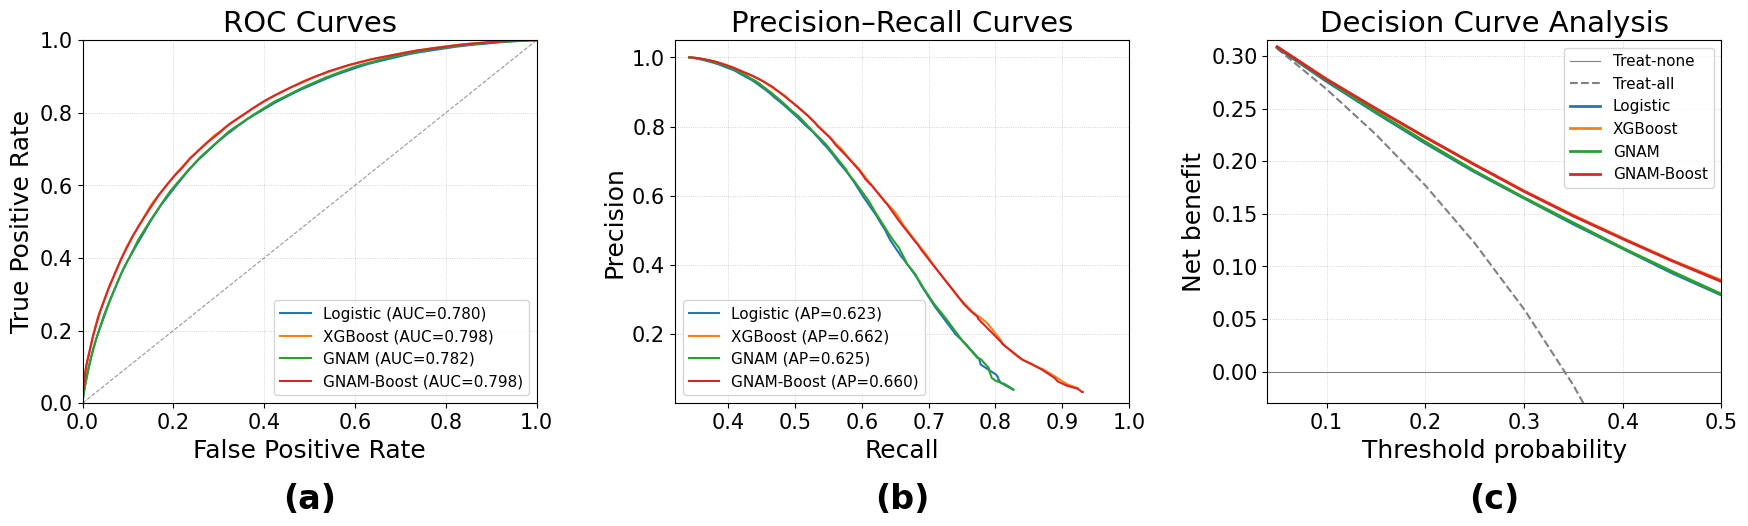

Combined triptych (a–c) saved to: C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\figs\fig_triptych_roc_pr_dca.png


In [4]:
# Figure 2 a–c: ROC + PR + DCA
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve, roc_curve

FIG_DIR.mkdir(parents=True, exist_ok=True)

def _mask_finite(y, p):
    y = np.asarray(y); p = np.asarray(p, dtype=float); m = np.isfinite(p)
    return y[m], p[m]

def metrics(y, p):
    y, p = _mask_finite(y, p)
    if y.size == 0 or len(np.unique(y)) < 2:
        return dict(auroc=np.nan, ap=np.nan, brier=np.nan,
                    roc=(np.array([0, 1]), np.array([0, 1])),
                    pr=(np.array([0, 1]), np.array([1, 0])))
    fpr, tpr, _ = roc_curve(y, p)
    rec, prec, _ = precision_recall_curve(y, p)
    return dict(auroc=float(roc_auc_score(y, p)), ap=float(average_precision_score(y, p)),
                brier=float(brier_score_loss(y, p)), roc=(fpr, tpr), pr=(rec, prec))

M = {
    "Logistic":   metrics(yte, p_logit),
    "XGBoost":    metrics(yte, p_xgb),
    "GNAM":       metrics(yte, p_gnam),
    "GNAM-Boost": metrics(yte, p_final),
}

COLORS = {"Logistic":"#1f77b4","XGBoost":"#ff7f0e","GNAM":"#2ca02c","GNAM-Boost":"#d62728"}
LW = 1.5
plt.rcParams.update({"font.size": 16 * 1.5,"axes.titlesize": 14 * 1.5,"axes.labelsize": 12 * 1.5,
                     "legend.fontsize": 10 * 1.1,"xtick.labelsize": 10 * 1.5,"ytick.labelsize": 10 * 1.5})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ROC
ax = axes[0]
ax.plot([0, 1], [0, 1], '--', linewidth=0.8, color="#999999")
for name in ["Logistic", "XGBoost", "GNAM", "GNAM-Boost"]:
    fpr, tpr = M[name]["roc"]; ax.plot(fpr, tpr, label=f"{name} (AUC={M[name]['auroc']:.3f})", color=COLORS[name], linewidth=LW)
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves"); ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.legend(loc="lower right")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

# PR
ax = axes[1]
for name in ["Logistic", "XGBoost", "GNAM", "GNAM-Boost"]:
    rec, prec = M[name]["pr"]; rec = np.asarray(rec); prec = np.asarray(prec); prec_plot = np.where(prec < 0.03, np.nan, prec)
    ax.plot(rec, prec_plot, label=f"{name} (AP={M[name]['ap']:.3f})", color=COLORS[name], linewidth=LW)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curves"); ax.set_xlim(0.32, 1); ax.set_ylim(0.001, 1.05); ax.legend(loc="lower left")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

# DCA
def decision_curve_net_benefit(y_true, p_pred, thresholds):
    y = np.asarray(y_true, dtype=int); p = np.asarray(p_pred, dtype=float); N = len(y); out = []
    for pt in thresholds:
        pred_pos = (p >= pt).astype(int)
        TP = ((pred_pos == 1) & (y == 1)).sum(); FP = ((pred_pos == 1) & (y == 0)).sum()
        nb = (TP / N) - (FP / N) * (pt / (1 - pt)); out.append(nb)
    return np.array(out)

ths = np.linspace(0.05, 0.50, 10)
curves = {
    "Treat-none": np.zeros_like(ths),
    "Treat-all":  [(yte.mean()) - (1 - yte.mean()) * (pt/(1-pt)) for pt in ths],
    "Logistic":   decision_curve_net_benefit(yte, p_logit, ths),
    "XGBoost":    decision_curve_net_benefit(yte, p_xgb, ths),
    "GNAM":       decision_curve_net_benefit(yte, p_gnam, ths),
    "GNAM-Boost": decision_curve_net_benefit(yte, p_final, ths),
}

ax = axes[2]
ax.axhline(0, color='gray', linewidth=0.8, label="Treat-none")
ax.plot(ths, curves["Treat-all"], color="gray", linestyle="--", label="Treat-all")
for name in ["Logistic", "XGBoost", "GNAM", "GNAM-Boost"]:
    ax.plot(ths, curves[name], color=COLORS[name], label=name, linewidth=2)
ax.set_xlabel("Threshold probability"); ax.set_ylabel("Net benefit")
ax.set_title("Decision Curve Analysis"); ax.set_xlim(0.04, 0.5); ax.set_ylim(-0.03, 0.315); ax.legend(loc="best")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

labels = ["(a)", "(b)", "(c)"]
for i, ax in enumerate(axes):
    ax.text(0.5, -0.22, labels[i], transform=ax.transAxes, fontsize=plt.rcParams["font.size"], fontweight="bold", ha="center", va="top")

plt.tight_layout()
trip_path = FIG_DIR / "fig_triptych_roc_pr_dca.png"
plt.savefig(trip_path, dpi=200, bbox_inches="tight")
plt.show(); plt.close()
print("Combined triptych (a–c) saved to:", trip_path)


Generated shape functions: ['Overload', 'EPI_WEEK', 'AGE_Y']


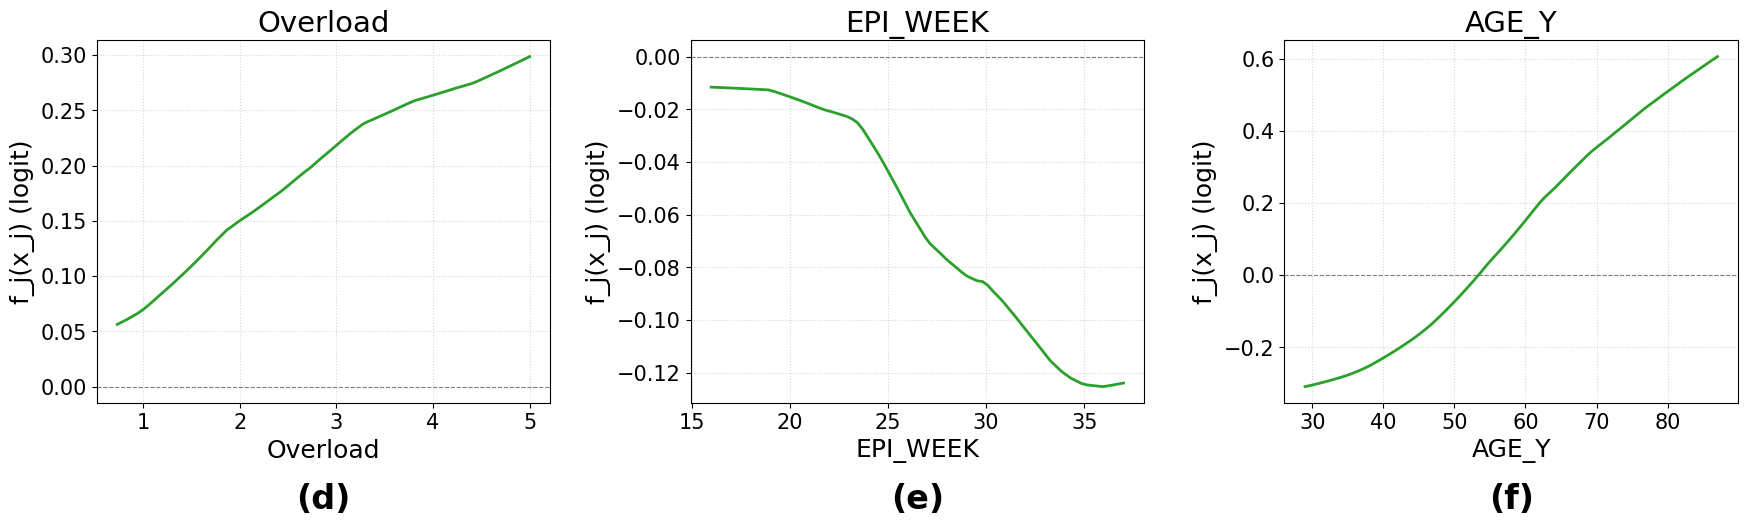

Saved as C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\figs\shapes\shape_triptych_overload_epiweek_age.png


In [5]:
# Figure 2 d–f: GNAM Shape Functions
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from pathlib import Path

# 复原类别展开名
try:
    ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    ohe_names = []
feat_names_full = list(num_cols) + list(bin_cols) + ohe_names
name_to_idx = {n: i for i, n in enumerate(feat_names_full)}

age_var = "AGE_Y" if "AGE_Y" in getattr(Xtr, "columns", []) else ("NU_IDADE_N" if "NU_IDADE_N" in getattr(Xtr, "columns", []) else None)
if age_var is None:
    raise RuntimeError("Age column not found (AGE_Y or NU_IDADE_N).")

Xt_ref = Xtr_t.mean(axis=0, keepdims=True)

# 载入 GNAM
import torch.nn as nn, torch.nn.functional as F
class ExULayer(nn.Module):
    def __init__(self, nonlin="softplus"):
        super().__init__(); self.w = nn.Parameter(torch.zeros(1)); self.b = nn.Parameter(torch.zeros(1)); self.nonlin = nonlin
    def forward(self, x):
        z = torch.exp(self.w) * (x - self.b)
        if self.nonlin == "softplus": return F.softplus(z)
        if self.nonlin == "tanh": return torch.tanh(z)
        return F.relu(z)

class FeatureNet(nn.Module):
    def __init__(self, hidden=96, dropout=0.20):
        super().__init__(); self.exu = ExULayer("softplus"); self.fc1 = nn.Linear(1, hidden); self.fc2 = nn.Linear(hidden, hidden // 2); self.fc3 = nn.Linear(hidden // 2, 1); self.dp = nn.Dropout(0.20)
    def forward(self, x):
        h = self.exu(x); h = F.relu(self.fc1(h)); h = self.dp(F.relu(self.fc2(h))); return self.fc3(h)

class GNAM(nn.Module):
    def __init__(self, n_features, hidden=96, dropout=0.20):
        super().__init__(); self.bias = nn.Parameter(torch.zeros(1)); self.fnets = nn.ModuleList([FeatureNet(hidden, dropout) for _ in range(n_features)])
    def forward(self, x):
        outs = [self.fnets[j](x[:, j:j+1]) for j in range(x.shape[1])]
        eta = self.bias + torch.stack(outs, dim=2).sum(dim=2); return eta.squeeze(1)

gnam = GNAM(n_features=Xtr_t.shape[1], hidden=96, dropout=0.20)
gnam.load_state_dict(torch.load(INT_DIR/"gnam_best.pt", map_location="cpu"))
gnam.eval()

def _curve_for(var_name, qlow=5, qhigh=95, n_points=80):
    if var_name not in name_to_idx:
        print(f"Feature {var_name} not found in preprocessed features."); return None
    j = name_to_idx[var_name]
    raw_vals = pd.to_numeric(Xtr[var_name], errors="coerce").dropna().astype(float)
    if raw_vals.empty: print(f"Feature {var_name} has no valid values."); return None
    x_raw = np.linspace(np.percentile(raw_vals, qlow), np.percentile(raw_vals, qhigh), n_points)
    if var_name in num_cols:
        idx_in_num = num_cols.index(var_name)
        scaler = preproc.named_transformers_["num"].named_steps["scaler"]
        mu = float(scaler.mean_[idx_in_num]); sd = float(scaler.scale_[idx_in_num])
        x_std = (x_raw - mu) / (sd + 1e-12)
    else:
        x_std = x_raw
    Xbatch = np.repeat(Xt_ref, len(x_std), axis=0); Xbatch[:, j] = x_std
    with torch.no_grad():
        xb = torch.tensor(Xbatch, dtype=torch.float32)
        fj = gnam.fnets[j](xb[:, j:j+1]).squeeze(1).cpu().numpy()
    return (x_raw, fj)

shape_curves = {}
for var in ["Overload", "EPI_WEEK", age_var]:
    res = _curve_for(var)
    if res is not None: shape_curves[var] = res
print("Generated shape functions:", list(shape_curves.keys()))

def save_triptych(shapes_dict, order, out_path):
    kept = [v for v in order if v in shapes_dict]
    if not kept: print("Slot is empty!"); return
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.rcParams.update({"font.size": 16 * 1.5,"axes.titlesize": 14 * 1.5,"axes.labelsize": 12 * 1.5,"xtick.labelsize": 10 * 1.5,"ytick.labelsize": 10 * 1.5})
    for ax, name in zip(axes, kept):
        x, y = shapes_dict[name]
        ax.plot(x, y, color="#2ca02c", linewidth=2)
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.set_axisbelow(True); ax.grid(True, which="both", linestyle=":", linewidth=0.8, color="#cccccc", alpha=0.8)
        ax.set_xlabel(name); ax.set_ylabel("f_j(x_j) (logit)"); ax.set_title(name)
    labels = ["(d)", "(e)", "(f)"]
    for i, ax in enumerate(axes):
        ax.text(0.5, -0.22, labels[i], transform=ax.transAxes, fontsize=plt.rcParams["font.size"], fontweight="bold", ha="center", va="top")
    fig.tight_layout(); out_path = Path(out_path); out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=200, bbox_inches="tight"); plt.show(); plt.close(fig)

triptych_path = Path(FIG_DIR) / "shapes" / "shape_triptych_overload_epiweek_age.png"
order = ["Overload", "EPI_WEEK", age_var]
save_triptych(shape_curves, order, triptych_path)
print("Saved as", triptych_path)


F:\Anaconda\envs\gnamboost\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP target: ['Overload', 'EPI_WEEK', 'AGE_Y']
Saved: C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\figs\shap_single\shap_Overload.png
Saved: C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\figs\shap_single\shap_EPI_WEEK.png
Saved: C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\figs\shap_single\shap_AGE_Y.png
C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\figs\fig2_residual_shap_overload_epiweek_age_panel.png


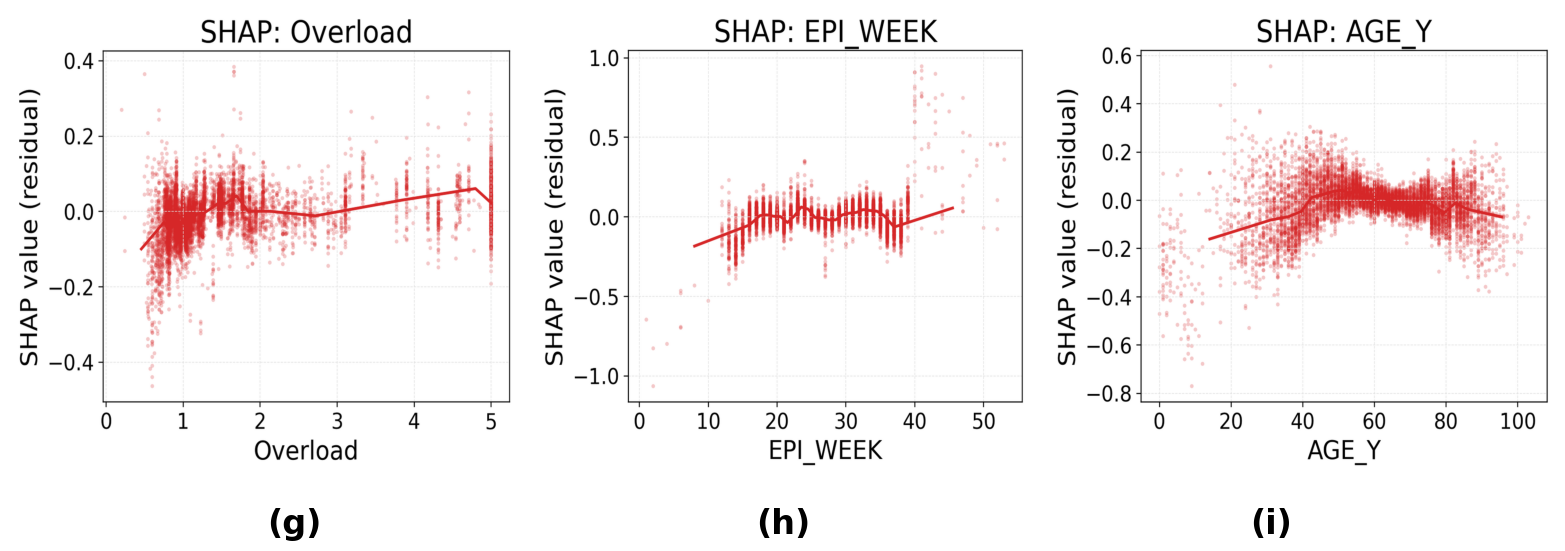

In [6]:
# Figure 2 g–i: GNAM-Boost Residual SHAP
import os, warnings

os.environ["TQDM_DISABLE"] = "1"
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import sys, subprocess, importlib
from pathlib import Path

COLORS = {"Logistic":"#1f77b4","XGBoost":"#ff7f0e","GNAM":"#2ca02c","GNAM-Boost":"#d62728"}

def _ensure(pkg):
    try:
        return importlib.import_module(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        return importlib.import_module(pkg)

try:
    from PIL import Image as PILImage
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pillow"])
    from PIL import Image as PILImage

# SHAP
shap = _ensure("shap")

# xgb booster
import xgboost as xgb
bst2 = xgb.Booster()
bst2.load_model(str(INT_DIR/"gnamboost_bst.json"))

try:
    ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    ohe_names = []
feat_names_full = list(num_cols) + list(bin_cols) + ohe_names
name_to_idx = {n: i for i, n in enumerate(feat_names_full)}

age_var = "AGE_Y" if "AGE_Y" in Xtr.columns else ("NU_IDADE_N" if "NU_IDADE_N" in Xtr.columns else None)
target_vars = ["Overload", "EPI_WEEK"] + ([age_var] if age_var else [])
print("SHAP target:", target_vars)

nsamp = min(8000, Xte_t.shape[0])
rng = np.random.RandomState(meta["seed"])
idx = rng.choice(Xte_t.shape[0], size=nsamp, replace=False)
Xte_sample = Xte_t[idx]

explainer = shap.TreeExplainer(bst2)
shap_values = explainer.shap_values(Xte_sample)

out_dir = Path(FIG_DIR) / "shap_single"
out_dir.mkdir(parents=True, exist_ok=True)
saved = []

plt.rcParams.update({
    "font.size": 16 * 1.5,
    "axes.titlesize": 14 * 1.5,
    "axes.labelsize": 12 * 1.5,
    "xtick.labelsize": 10 * 1.5,
    "ytick.labelsize": 10 * 1.5,
})

def _binned_line(x, y, bins=24):
    x = np.asarray(x); y = np.asarray(y)
    if len(x) == 0:
        return np.array([]), np.array([])
    qs = np.linspace(0, 1, bins + 1)
    edges = np.quantile(x, qs)
    edges[0] -= 1e-9; edges[-1] += 1e-9
    mids, means = [], []
    for a, b in zip(edges[:-1], edges[1:]):
        m = (x >= a) & (x < b)
        if m.any():
            mids.append((a + b) / 2.0)
            means.append(np.mean(y[m]))
    return np.array(mids), np.array(means)

custom_titles = {
    "Overload": "SHAP: Overload",
    "EPI_WEEK": "SHAP: EPI_WEEK",
    "AGE_Y": "SHAP: AGE_Y",
    "NU_IDADE_N": "SHAP: AGE_Y",
}

for var in target_vars:
    if not var or var not in name_to_idx:
        print(f"Var not exist: {var}")
        continue
    j = name_to_idx[var]
    x = Xte_sample[:, j]
    y_ = shap_values[:, j]

    if var in num_cols:
        idx_in_num = num_cols.index(var)
        scaler = preproc.named_transformers_["num"].named_steps["scaler"]
        mu = float(scaler.mean_[idx_in_num])
        sd = float(scaler.scale_[idx_in_num])
        x = x * sd + mu

    plt.figure(figsize=(6, 5))
    plt.scatter(x, y_, s=8, alpha=0.25, color=COLORS["GNAM-Boost"], edgecolors='none')
    xm, ym = _binned_line(x, y_, bins=24)
    if len(xm) > 1:
        plt.plot(xm, ym, color=COLORS["GNAM-Boost"], linewidth=2)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, color="#e0e0e0", alpha=0.9)
    plt.xlabel(var)
    plt.ylabel("SHAP value (residual)")
    plt.title(custom_titles.get(var, f"SHAP: {var}"))
    plt.tight_layout()
    outp = out_dir / f"shap_{var}.png"
    plt.savefig(outp, dpi=220, bbox_inches="tight")
    plt.close()
    saved.append(str(outp))
    print("Saved:", outp)

def stitch_horiz(images, outfile, padding=40, bg=(255,255,255)):
    imgs = [PILImage.open(p).convert("RGB") for p in images]
    max_h = max(im.size[1] for im in imgs)
    resized = []
    for im in imgs:
        w, h = im.size
        if h != max_h:
            new_w = int(round(w * (max_h / h)))
            im = im.resize((new_w, max_h), PILImage.LANCZOS)
        resized.append(im)
    total_w = sum(im.size[0] for im in resized) + padding * (len(resized) - 1)
    canvas = PILImage.new("RGB", (total_w, max_h), color=bg)
    x = 0
    for i, im in enumerate(resized):
        canvas.paste(im, (x, 0))
        x += im.size[0] + (padding if i < len(resized)-1 else 0)
    canvas.save(outfile, quality=95)
    return outfile

panel_paths = [p for p in saved if Path(p).exists()]
panel_out = Path(FIG_DIR) / "fig2_residual_shap_overload_epiweek_age_panel.png"
stitch_horiz(panel_paths, str(panel_out), padding=40, bg=(255,255,255))
print(panel_out)

panel_img = PILImage.open(panel_out).resize((3495, 1053), resample=PILImage.LANCZOS)
panel_img.save(panel_out, quality=95)
fig, ax = plt.subplots(figsize=(18, 6))
ax.imshow(panel_img)
ax.axis('off')

labels = ["(g)", "(h)", "(i)"]
w = panel_img.size[0]
canvas_h = panel_img.size[1]
resized_ws = []
for p in panel_paths:
    im = PILImage.open(p)
    w_i, h_i = im.size
    w_resized = int(round(w_i * (canvas_h / h_i)))
    resized_ws.append(w_resized)
sum_w = sum(resized_ws)
pad_scaled = (w - sum_w) / (len(resized_ws) - 1) if len(resized_ws) > 1 else 0
centers_px = []
x_cursor = 0
for i, w_i in enumerate(resized_ws):
    centers_px.append(x_cursor + w_i / 2.0)
    x_cursor += w_i + (pad_scaled if i < len(resized_ws) - 1 else 0)
total_w = w
for cx, lab in zip(centers_px, labels):
    ax.text(cx / total_w, -0.07, lab,
            transform=ax.transAxes,
            fontsize=plt.rcParams["font.size"], fontweight="bold",
            ha="center", va="top")
plt.subplots_adjust(bottom=0.18)
plt.tight_layout()
plt.show()
plt.close()


Mapping By Group： {'Age': 1, 'Education': 7, 'Ethnicity': 6, 'Sex': 3, 'Hospital strain': 1, 'Renal disease': 1, 'Cardiovascular disease': 1, 'Immunosuppression': 1, 'Diabetes': 1, 'Hematologic disease': 1, 'Asthma': 1, 'Pulmonary disease': 1}
GNAM main efficiency


Feature  GNAM_main  XGB_residual     Total
0                      Age   0.503566      0.040776  0.544342
1                Education   0.228791      0.029386  0.258177
3                      Sex   0.169688      0.019920  0.189608
9      Hematologic disease   0.160455      0.028571  0.189026
4          Hospital strain   0.115517      0.046816  0.162332
8                 Diabetes   0.124236      0.002039  0.126275
6   Cardiovascular disease   0.100929      0.004927  0.105856
2                Ethnicity   0.071249      0.032269  0.103518
5            Renal disease   0.092322      0.006601  0.098923
7        Immunosuppression   0.077913      0.016370  0.094283
11       Pulmonary disease   0.061625      0.022721  0.084345
10                  Asthma   0.007056      0.003174  0.010230

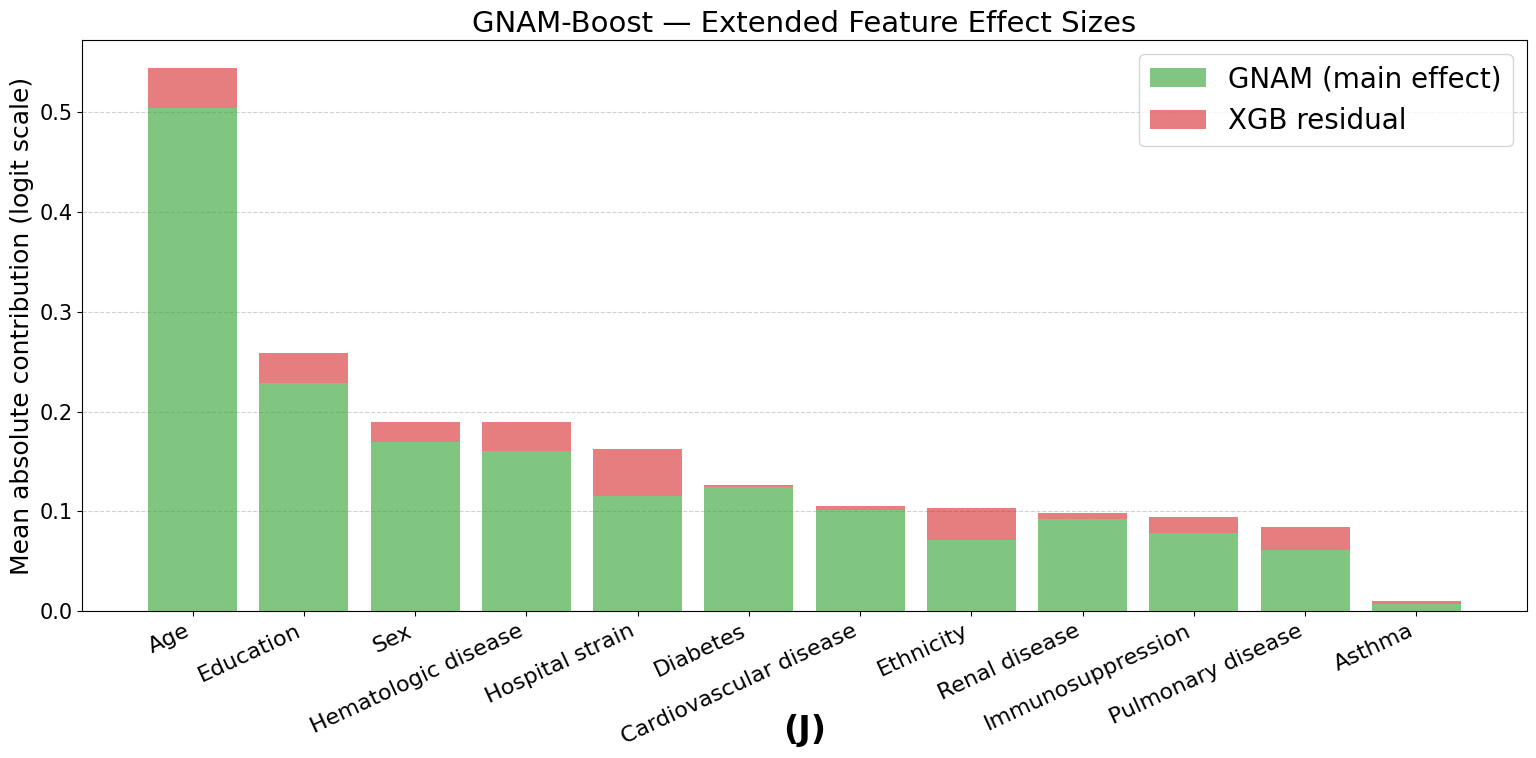

Saved as C:\Users\Nicee\Desktop\kenkyu\gnamboost_outputs\figs\fig_gnamboost_effect_sizes_full_grid.png


In [7]:
# Figure 2 J
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from pathlib import Path
import importlib, sys, subprocess

COLORS = {"GNAM":"#2ca02c","GNAM-Boost":"#d62728"}

# 载入 GNAM
import torch.nn as nn, torch.nn.functional as F
class ExULayer(nn.Module):
    def __init__(self, nonlin="softplus"):
        super().__init__(); self.w = nn.Parameter(torch.zeros(1)); self.b = nn.Parameter(torch.zeros(1)); self.nonlin = nonlin
    def forward(self, x):
        z = torch.exp(self.w) * (x - self.b)
        if self.nonlin == "softplus": return F.softplus(z)
        if self.nonlin == "tanh": return torch.tanh(z)
        return F.relu(z)
class FeatureNet(nn.Module):
    def __init__(self, hidden=96, dropout=0.20):
        super().__init__(); self.exu = ExULayer("softplus"); self.fc1 = nn.Linear(1, hidden); self.fc2 = nn.Linear(hidden, hidden // 2); self.fc3 = nn.Linear(hidden // 2, 1); self.dp = nn.Dropout(0.20)
    def forward(self, x):
        h = self.exu(x); h = F.relu(self.fc1(h)); h = self.dp(F.relu(self.fc2(h))); return self.fc3(h)
class GNAM(nn.Module):
    def __init__(self, n_features, hidden=96, dropout=0.20):
        super().__init__(); self.bias = nn.Parameter(torch.zeros(1)); self.fnets = nn.ModuleList([FeatureNet(hidden, dropout) for _ in range(n_features)])
    def forward(self, x):
        outs = [self.fnets[j](x[:, j:j+1]) for j in range(x.shape[1])]
        eta = self.bias + torch.stack(outs, dim=2).sum(dim=2); return eta.squeeze(1)

gnam = GNAM(n_features=Xtr_t.shape[1], hidden=96, dropout=0.20)
gnam.load_state_dict(torch.load(INT_DIR/"gnam_best.pt", map_location="cpu")); gnam.eval()

# 名称映射
try:
    ohe = preproc.named_transformers_["cat"].named_steps["ohe"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    ohe_names = []
feat_names_full = list(num_cols) + list(bin_cols) + ohe_names
name_to_idx = {n: i for i, n in enumerate(feat_names_full)}

age_var = "NU_IDADE_N"
assert age_var in Xtr.columns, "No NU_IDADE_N"

def _find_group_indices():
    groups = {}
    if age_var in name_to_idx: groups["Age"] = [name_to_idx[age_var]]
    state_cols = [c for c in ohe_names if c.startswith("SG_UF")]
    if state_cols: groups["State"] = [name_to_idx[c] for c in state_cols if c in name_to_idx]
    elif "SG_UF" in name_to_idx: groups["State"] = [name_to_idx["SG_UF"]]
    if "CS_ZONA" in name_to_idx: groups["City type"] = [name_to_idx["CS_ZONA"]]
    escol_cols = [c for c in ohe_names if c.startswith("CS_ESCOL_N")]
    if escol_cols: groups["Education"] = [name_to_idx[c] for c in escol_cols if c in name_to_idx]
    elif "CS_ESCOL_N" in name_to_idx: groups["Education"] = [name_to_idx["CS_ESCOL_N"]]
    raca_cols = [c for c in ohe_names if c.startswith("CS_RACA")]
    if raca_cols: groups["Ethnicity"] = [name_to_idx[c] for c in raca_cols if c in name_to_idx]
    elif "CS_RACA" in name_to_idx: groups["Ethnicity"] = [name_to_idx["CS_RACA"]]
    sexo_cols = [c for c in ohe_names if c.startswith("CS_SEXO")]
    if sexo_cols: groups["Sex"] = [name_to_idx[c] for c in sexo_cols if c in name_to_idx]
    elif "CS_SEXO" in name_to_idx: groups["Sex"] = [name_to_idx["CS_SEXO"]]
    if "Overload" in name_to_idx: groups["Hospital strain"] = [name_to_idx["Overload"]]
    for lab, cname in [
        ("Renal disease", "RENAL"),("Cardiovascular disease", "CARDIOPATI"),("Immunosuppression", "IMUNODEPRE"),
        ("Diabetes", "DIABETES"),("Hematologic disease", "HEMATOLOGI"),("Asthma", "ASMA"),("Pulmonary disease", "PNEUMOPATI"),
    ]:
        if cname in name_to_idx: groups[lab] = [name_to_idx[cname]]
    order = ["Age","State","City type","Education","Ethnicity","Sex","Hospital strain",
             "Renal disease","Cardiovascular disease","Immunosuppression","Diabetes","Hematologic disease","Asthma","Pulmonary disease"]
    return {k:v for k,v in ((k,groups.get(k,[])) for k in order) if v}

group_indices = _find_group_indices()
print("Mapping By Group：", {k: len(v) for k,v in group_indices.items()})

def gnam_decompose_in_batches(model, X_mat, batch=4096):
    n, p = X_mat.shape; parts = np.zeros((n, p), dtype=np.float32)
    with torch.no_grad():
        for start in range(0, n, batch):
            end = min(start+batch, n); xb = torch.tensor(X_mat[start:end], dtype=torch.float32)
            chunk = []
            for j in range(p):
                outj = model.fnets[j](xb[:, j:j+1]).squeeze(1).cpu().numpy()
                chunk.append(outj)
            parts[start:end, :] = np.stack(chunk, axis=1)
    bias = float(model.bias.detach().cpu().numpy().reshape(1)[0]); return bias, parts

print("GNAM main efficiency")
_ = gnam.eval()
bias_gnam, parts_te = gnam_decompose_in_batches(gnam, Xte_t)

gnam_group_abs = {}
for k, idxs in group_indices.items():
    contrib = parts_te[:, idxs].sum(axis=1) if len(idxs)>1 else parts_te[:, idxs[0]]
    gnam_group_abs[k] = float(np.mean(np.abs(contrib)))

# SHAP (XGB residual)
import xgboost as xgb
bst2 = xgb.Booster(); bst2.load_model(str(INT_DIR/"gnamboost_bst.json"))

def _ensure(pkg):
    try:
        return importlib.import_module(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        return importlib.import_module(pkg)
shap = _ensure("shap")

nsamp = min(8000, Xte_t.shape[0])
rng = np.random.RandomState(meta["seed"]); idx = rng.choice(Xte_t.shape[0], size=nsamp, replace=False)
Xte_sample = Xte_t[idx]
explainer = shap.TreeExplainer(bst2); shap_vals = explainer.shap_values(Xte_sample)

xgb_group_abs = {}
for k, idxs in group_indices.items():
    s = shap_vals[:, idxs].sum(axis=1) if len(idxs)>1 else shap_vals[:, idxs[0]]
    xgb_group_abs[k] = float(np.mean(np.abs(s)))

rows = []
for k in group_indices.keys():
    g_main = gnam_group_abs.get(k, 0.0); g_res  = xgb_group_abs.get(k, 0.0)
    rows.append({"Feature": k, "GNAM_main": g_main, "XGB_residual": g_res, "Total": g_main + g_res})

df_eff = pd.DataFrame(rows).sort_values("Total", ascending=False)
display(df_eff)

# plot
out_dir = Path(FIG_DIR); out_dir.mkdir(parents=True, exist_ok=True)
plt.rcParams.update({"font.size": 16 * 1.5,"axes.titlesize": 14 * 1.5,"axes.labelsize": 12 * 1.5,"legend.fontsize": 10 * 2,"xtick.labelsize": 10 * 1.6,"ytick.labelsize": 10 * 1.5})

fig, ax = plt.subplots(figsize=(15.886, 8.1))
x = np.arange(len(df_eff)); main = df_eff["GNAM_main"].values; resd = df_eff["XGB_residual"].values
ax.set_axisbelow(True); ax.grid(True, which="both", axis="y", linestyle="--", linewidth=0.8, color="#cccccc", alpha=0.9, zorder=0)
ax.bar(x, main, color=COLORS["GNAM"], alpha=0.6, label="GNAM (main effect)", zorder=3)
ax.bar(x, resd, bottom=main, color=COLORS["GNAM-Boost"], alpha=0.6, label="XGB residual", zorder=3)
ax.set_xticks(x); ax.set_xticklabels(df_eff["Feature"], rotation=25, ha="right")
ax.set_ylabel("Mean absolute contribution (logit scale)")
ax.set_title("GNAM-Boost — Extended Feature Effect Sizes"); ax.legend(); fig.tight_layout()
ax.text(0.5, -0.18, "(J)", transform=ax.transAxes, fontsize=plt.rcParams["font.size"], fontweight="bold", ha="center", va="top")
fig_path = out_dir / "fig_gnamboost_effect_sizes_full_grid.png"
plt.savefig(fig_path, dpi=220, bbox_inches="tight"); plt.show(); plt.close()
print("Saved as", fig_path)
